# Using SNP mismatches to delimit multilocus lineages (MLLs)
Individuals belonging to the same clonal lineages should show higher-than-expected identity across loci. This is usually explored by plotting a histogram of pairwise distances and looking for a peak with the lowest distances between individuals, and a saddle point, giving us a threshold distance to distinguish intraclonal and interclonal comparisons.

Here we used hamming distance (i.e. any mismatch in genotype), divided by total number of sites compared for a given pair, as a distance measure to make the histogram.

Let's start by preparing a workspace: setting default plot options and loading the [magrittr library](https://cran.r-project.org/web/packages/magrittr/vignettes/magrittr.html) for easier manipulation of data with *pipes* (`%>%` and others).

In [1]:
options(repr.plot.width=7, repr.plot.height=5, jupyter.plot_scale = 1)

library(magrittr)

Load a table produced by `pairwise_mismatches.r` script with additional information on species and hybrid biotypes included:

In [2]:
distances <- read.csv("LOH_dist.csv")[,-1] # [,-1] excludes rownames exported by write.csv()
head(distances)

,anim1,anim2,total,mismatch,p_mismatch,bio1,bio2
,<chr>,<chr>,<int>,<int>,<dbl>,<chr>,<chr>
1,csc008,csc009,80213,55478,0.6916335,TT,EE
2,csc009,csc011,103708,67617,0.6519941,EE,EET
3,csc008,csc011,87545,56752,0.6482609,TT,EET
4,csc008,csc012,85944,56252,0.6545192,TT,EEN
5,csc009,csc012,101650,56782,0.5586030,EE,EEN
6,csc011,csc012,124082,22653,0.1825648,EET,EEN


The two `bio` columns describe species or hybrid type of samples in the two `anim` columns:

- anim1 ~ bio1
- anim2 ~ bio2

Species and hybrid biotypes in the dataset:

In [3]:
c(distances$bio1, distances$bio2) %>% unique

[1] "TT"  "EE"  "EET" "EEN" "NN"  "ET"  "EN"  "ETT"

## Plots
Now we can plot histograms using the `p_mismatch` column, i.e. the proportion of mismatches in total positions considered for each pair:

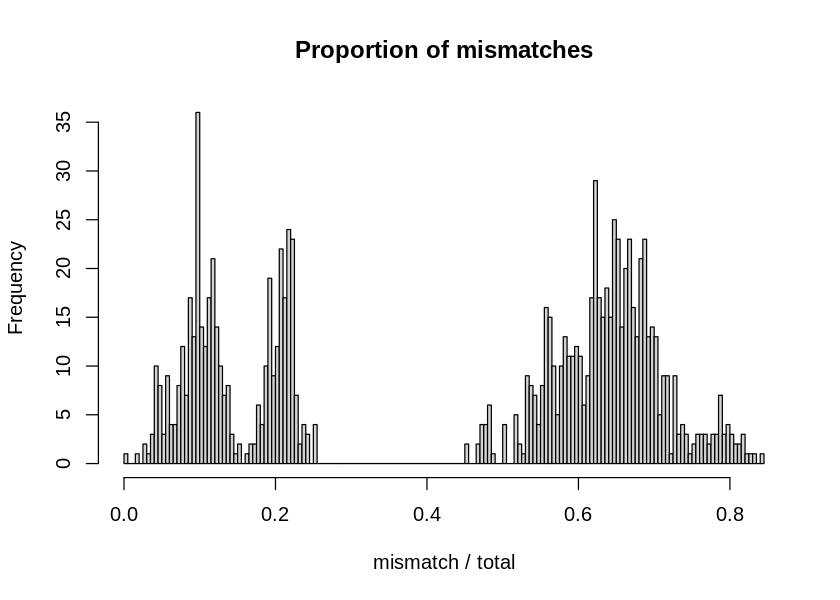

In [4]:
hist(distances$p_mismatch, main="Proportion of mismatches", breaks=150, xlab="mismatch / total")

Let's deconstruct the above histogram by subsetting the data to several categories and plotting them.

The plots below show distances (in terms of proportion of mismatches between genotypes) for these groups:
- **TT** = within *C. taenia*
- **EE** = within *C. elongatoides*
- **TT/EE** = between *C. taenia* and *C. elongatoides*
- **Hybrids** = all asexual hybrids

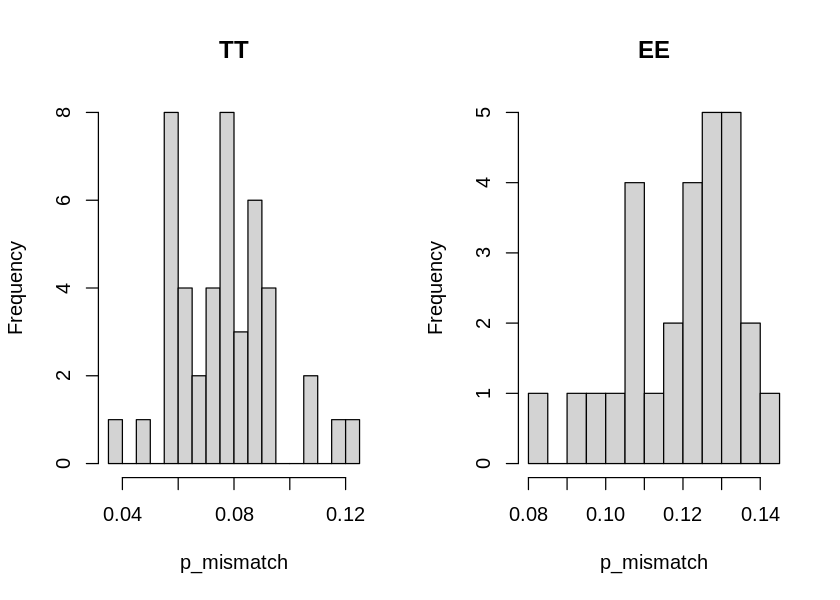

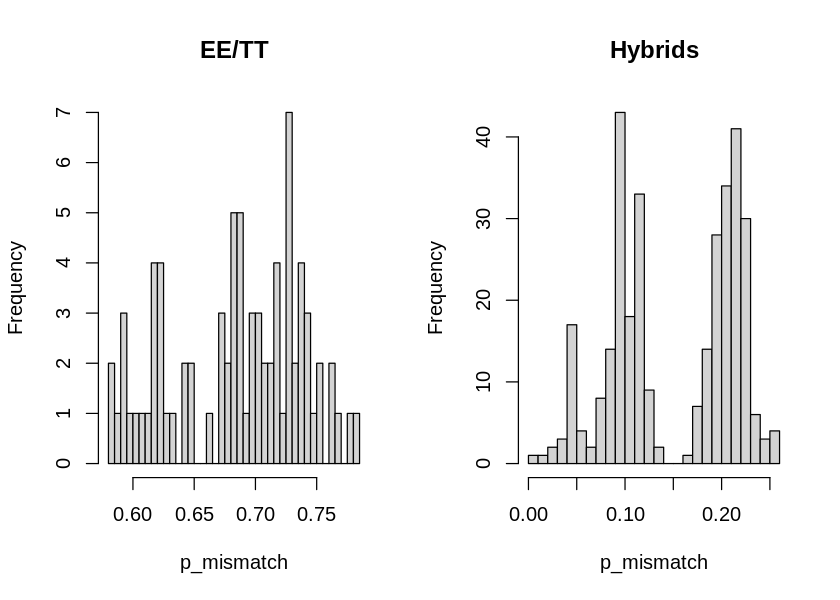

In [5]:
par(mfrow=c(1,2))
distances %>% subset(bio1=="TT" & bio2=="TT") %$% hist(p_mismatch, breaks=20, main="TT")
distances %>% subset(bio1=="EE" & bio2=="EE") %$% hist(p_mismatch, breaks=20, main="EE")
distances %>% subset((bio1=="EE" & bio2=="TT") | (bio1=="TT" & bio2=="EE")) %$% hist(p_mismatch, breaks=30, main="EE/TT")
distances %>% subset(grepl("ET|EN",bio1) & grepl("ET|EN",bio2)) %$% hist(p_mismatch, breaks=30, main="Hybrids")

We can see that distances **within sexual species** (here TT or EE) have a peak around 0.1, with *C. taenia* (TT) showing smaller distances than *C. elongatoides*, which is expected, given its smaller effective population size.

The right-most peak with the largest distances corresponds to comparisons **between sexual species** EE and TT.

> Note that we don't show all combinations here - there is also *C. tanaitica*, or comparisons between sexuals and asexual hybrids. But we are interested in lineages within asexuals, so we will leave these illustrative examples as they are now.

Lastly, the **asexual hybrids** show several peaks. Let's zoom in on their histogram:

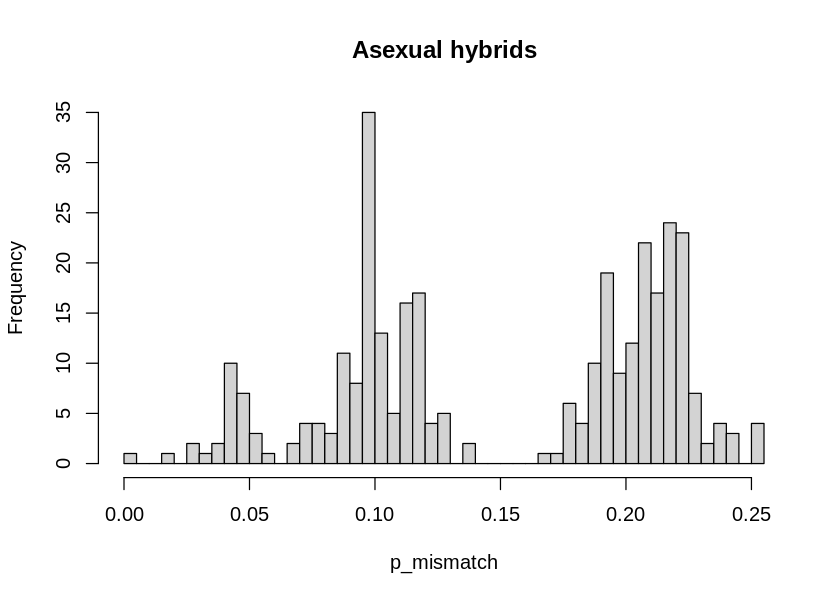

In [6]:
distances %>% subset(grepl("ET|EN",bio1) & grepl("ET|EN",bio2)) %$% 
    hist(p_mismatch, breaks=50, main="Asexual hybrids")

Let's save this subset of data into a new object `hybs` for easier access:

In [7]:
hybs <- distances %>% subset(grepl("ET|EN",bio1) & grepl("ET|EN",bio2))

# check present genomotypes
c(hybs$bio1, hybs$bio2) %>% unique

[1] "EET" "EEN" "ET"  "EN"  "ETT"

## Exploring peaks
First, let's see which pairwise comparisons contribute to the right-most peaks, above the value 0.15:

In [8]:
hybs %>% 
    subset(p_mismatch>0.15) %$% 
    paste(bio1,bio2, sep="-") %>% unique

[1] "EET-EEN" "EEN-ET"  "EEN-EET" "ET-EEN"  "ET-EN"   "EET-EN"  "EN-EET" 
 [8] "EEN-ETT" "EN-ETT"  "EN-ET"

As we can see, these large distances mostly correspond to combinations of hybrids with different genomic compositions. In particular, we always see an *elongatoides-taenia* hybrid (ET / EET / ETT) paired with an *elongatoides-tanaitica* hybrid (EN / EEN).

Next, we can have a look at the middle peak, at distances between 0.06 & 0.15:

In [9]:
hybs %>% 
    subset(p_mismatch<0.15 & p_mismatch>0.06) %$% 
    paste(bio1,bio2, sep="-") %>% unique

[1] "EEN-EEN" "EET-ET"  "ET-EET"  "ET-ET"   "EEN-EN"  "EN-EEN"  "ET-ETT" 
 [8] "EET-ETT" "ETT-ETT" "ETT-ET"

Here the combinations are between different genomotypes of hybrids, but always within one of the two main hybrid types: either *elongatoides-taenia* hybrids (E & T genomes) or *elongatoides-tanaitica* hybrids (E & N genomes).

Lastly, let's see the pairs contributing to the small left-most peak, where distances are below 0.06:

In [10]:
hybs %>% 
    subset(p_mismatch<0.06) %$% 
    paste(bio1,bio2, sep="-") %>% unique

[1] "EEN-EEN" "EET-EET" "ET-ET"   "EN-EN"   "ETT-ETT" "ET-ETT"  "ETT-ET"

These distances *nearly always* correspond to pairs from within the same genomotypes, except the last two pairs: ET-ETT & ETT-ET. If we look up the samples involved, we see they are young hybrids from the same sampling site in Poland - HZ0701:

In [11]:
hybs %>% 
    subset(((bio1=="ET" & bio2=="ETT") | (bio1=="ETT" & bio2=="ET")) & p_mismatch<0.06)

,anim1,anim2,total,mismatch,p_mismatch,bio1,bio2
,<chr>,<chr>,<int>,<int>,<dbl>,<chr>,<chr>
908,csc067,csc087,108380,5038,0.04648459,ET,ETT
909,csc057,csc087,98755,4537,0.04594198,ET,ETT
951,csc087,csc089,115557,6173,0.05341952,ETT,ET
995,csc087,csc090,114198,4921,0.04309182,ETT,ET


Having a peak of low distances, composed of sample pairs drawn mostly from the same genomotypes, is a good starting point for delimiting MLLs, but we are not done yet.

First, we are unsure that our method can detect clonal lineages across different genomotypes (e.g. after polyploidization event turning ET into EET or ETT).

Another problem is that some pairs of genomotypes from within the small peak also appear in the middle peak of intermediate distances - are they also from the same MLLs? Where is the line?

To get these answers, we now have to look at the samples themselves and how they group together into trios and larger groups. At some point we arrive at conflicting MLL assignments, at which point we can consider delimiting a new MLL.